In [ ]:
## TODO: Add Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

In [4]:
from hit_finding.constants import *
from hit_finding.metrics import *
from learning_tabular.constants import CHANNELS, FAMILIES, LABEL_FIELD
from learning_tabular.preprocessing import load_plate_csv, list_columns
from reproducibility.percantage_replicates_utils import *

In [5]:
# from os import chdir, scandir, makedirs
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
import seaborn as sns


from tqdm.notebook import tqdm
from glob import glob

# from itertools import cycle
# from multiprocessing import Pool, cpu_count

import pandas as pd
import numpy as np
import json
import pickle

In [6]:
cols = json.load(open('/storage/users/g-and-n/plates/columns-fs.json', 'r'))
# cols = json.load(open('/storage/users/g-and-n/plates/columns.json', 'r'))

chans = [c for c in cols.keys() if c not in ['GENERAL', 'MIXED']]
chans

del cols['GENERAL']
# del cols['MIXED'] 

cols['ALL'] = sum(cols.values(), [])
num_channels_all = len(cols['ALL'] )

# sum(cols.values(),[])
chans
num_channels_all
# cols['ALL']
# num_cols = [len(c in cols) for c in channels]

169

In [15]:
zscores = {
    # '4to1':{'path':f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores'},
    # '2to1':{'path':f'/storage/users/g-and-n/tabular_models_results/21/ALL/zscores'},
    # 'pure': {'path':f'/storage/users/g-and-n/plates/csvs'},
    '1to1':{'path':f'/storage/users/g-and-n/tabular_models_results/111/ALL/zscores'},
    'raw':{'path': f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/pure/raw'},
    # '5to5':{'path':f'/storage/users/g-and-n/tabular_models_results/55/ALL/zscores'},
}

# get plate numbers
cur_fld = f'/storage/users/g-and-n/tabular_models_results/41/ALL/'
all_plates = glob(os.path.join(cur_fld, 'zscores', '*'))

plate_nums = [
    25579, 25580, 25581, 25583,
    25891, 25892, 25903, 25911,
    24646, 24647, 24648, 24651,
#     26724, 26730, 26744, 26745,
#     25993, 25994, 25997, 26002,
#     24638, 24639, 24640, 24641,
#     25904, 25912, 25913, 25914,
#     26767, 26768, 26771, 26772,
#     24514, 24515, 24516, 24517,
#     24656, 24657, 24661, 24663,
#     26681, 26682, 26683, 26684,
#     26666, 26668, 26669, 26786,
#     26702, 26703, 26739, 26748,
#     25689, 25690, 25692, 25724,
#     24652, 24653, 24654, 24655,
#     24756, 24758, 24759, 24773,
#     26640, 26641, 26642, 26643,
#     24684, 24685, 24687, 24688,
#     26685, 26688, 26695, 26705,
#     25925, 25929, 25931, 25935
]
# plate_nums = [f'{p}.csv' for p in plate_nums]
# plate_nums = [os.path.split(plate)[-1] for plate in all_plates]
plate_nums = ['24277.csv','25579.csv','24302.csv','25708.csv', '25724.csv']
# plate_nums = [f'{p}.csv' for p in plate_nums]
plate_nums

['24277.csv', '25579.csv', '24302.csv', '25708.csv', '25724.csv']

In [16]:
# load zscores
for model in zscores.keys():
    plates =  [os.path.join(zscores[model]['path'], plate) for plate in plate_nums]
    zscores[model]['all'] = pd.concat([pd.read_csv(pth, index_col=[0, 1, 2, 3]) for pth in plates])

## Investigate Plate Effects

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import umap


pcas={}
tsnes={}
umaps={}

for model in zscores.keys():
    if model!='pure':
        x = zscores[model]['all'][cols['ALL']]
        x= x.fillna(0)
        
        sc = StandardScaler()
        X_scaled = sc.fit_transform(x.values)
        
        print('Running PCA...')
        
        pca = PCA(n_components=2)
        # x_pca = pca.fit_transform(X_scaled, allow_nan=True)
        pcas[model] = pca.fit_transform(X_scaled)
        
        print('Running TSNE...')
        
        t_sne = manifold.TSNE(
            n_components=2,
            perplexity=25,
            init="random",
            n_iter=250,
            random_state=0,
        )
        tsnes[model] = t_sne.fit_transform(X_scaled)
        
        print('Running UMAP...')
        
        reducer = umap.UMAP()
        umaps[model] = reducer.fit_transform(X_scaled)


Running PCA...
Running TSNE...


/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Running UMAP...
Running PCA...
Running TSNE...


/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Running UMAP...


1to1 with (1840, 175)


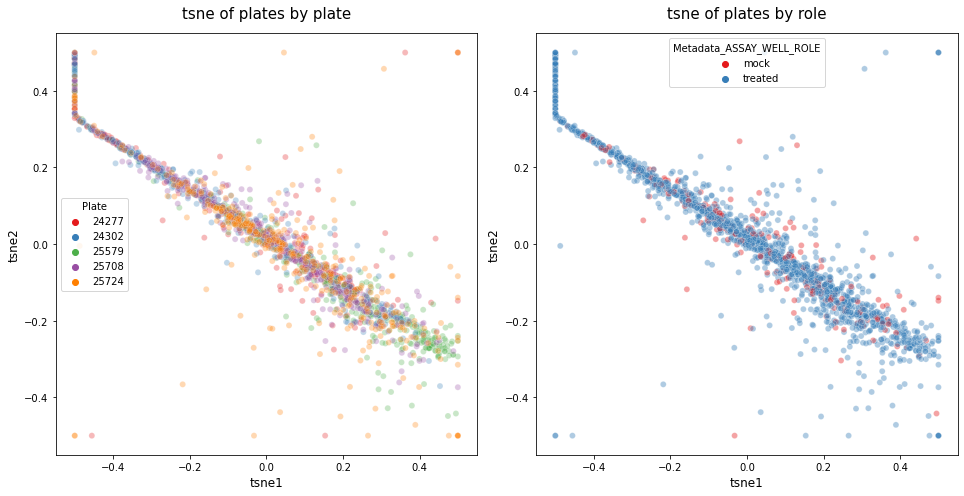

raw with (1920, 175)


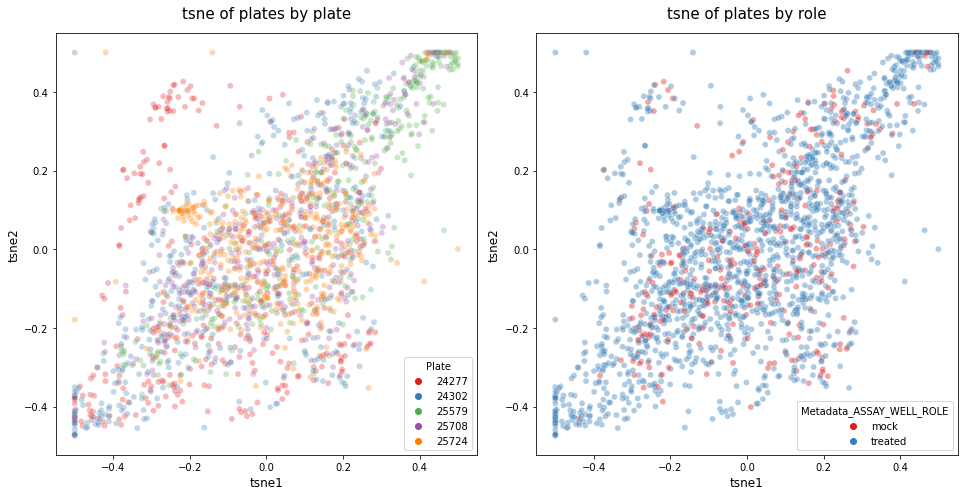

In [22]:
lim =0.5
method = 'tsne'
for model in pcas.keys():
    if model!='pure':
        a = zscores[model]['all'][cols['ALL']].copy()
        b = pd.DataFrame(tsnes[model],columns=[f'{method}1',f'{method}2']).copy()
        b[b>lim]=lim
        b[b<-lim]=-lim
        c = pd.concat([a.reset_index(),b],axis=1)
        # c[c['PCA1']>50]
        print(f'{model} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5, 7))
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Plate',alpha=0.3, palette='Set1', ax=ax[0])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.4, palette='Set1', ax=ax[1])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)

        ax[0].set_title(f'{method} of plates by plate', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        # ax[2].set_title("PCA of plates by sample", fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        ax[0].set_xlabel(f'{method}1', fontsize=12)
        ax[0].set_ylabel(f'{method}2', fontsize=12)

        ax[1].set_xlabel(f'{method}1', fontsize=12)
        ax[1].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

1to1 with (1840, 175)


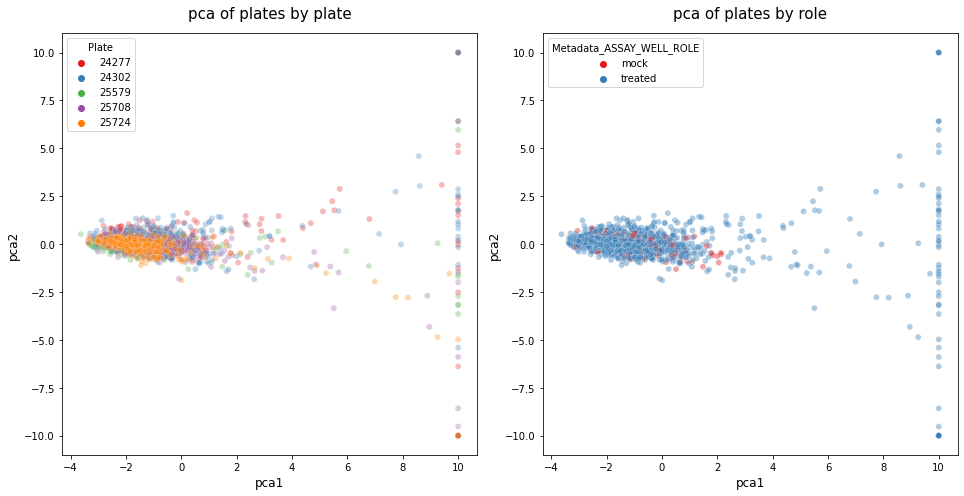

raw with (1920, 175)


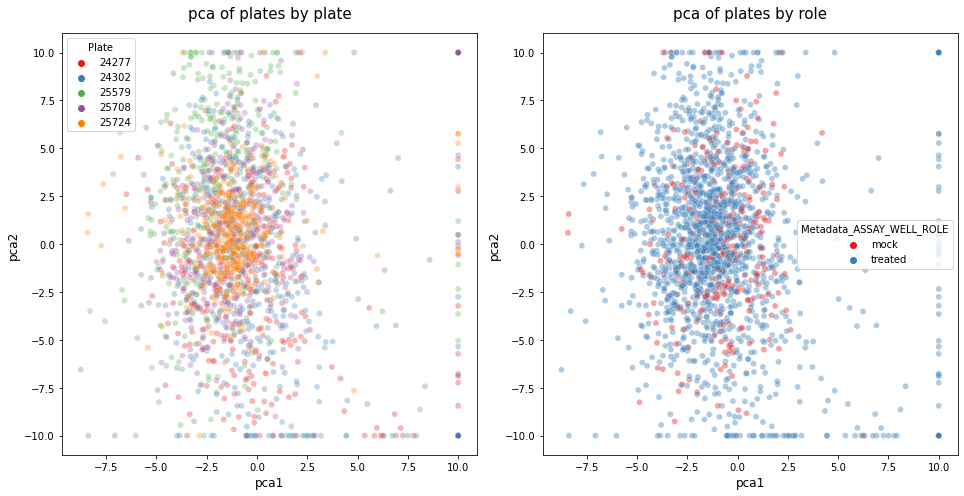

In [23]:
lim =10
method = 'pca'
for model in pcas.keys():
    if model!='pure':
        a = zscores[model]['all'][cols['ALL']].copy()
        b = pd.DataFrame(pcas[model],columns=[f'{method}1',f'{method}2']).copy()
        b[b>lim]=lim
        b[b<-lim]=-lim
        c = pd.concat([a.reset_index(),b],axis=1)
        # c[c['PCA1']>50]
        print(f'{model} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5, 7))
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Plate',alpha=0.3, palette='Set1', ax=ax[0])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.4, palette='Set1', ax=ax[1])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)

        ax[0].set_title(f'{method} of plates by plate', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        # ax[2].set_title("PCA of plates by sample", fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        ax[0].set_xlabel(f'{method}1', fontsize=12)
        ax[0].set_ylabel(f'{method}2', fontsize=12)

        ax[1].set_xlabel(f'{method}1', fontsize=12)
        ax[1].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

1to1 with (1840, 175)


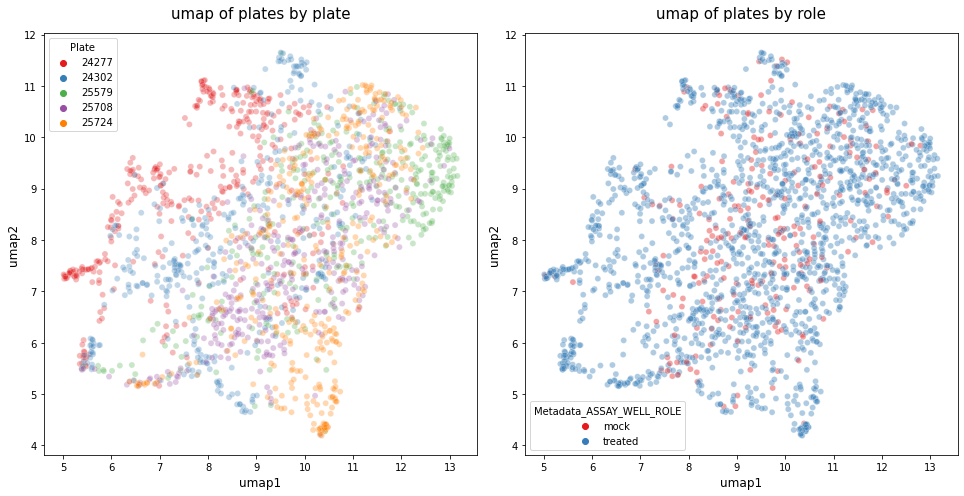

raw with (1920, 175)


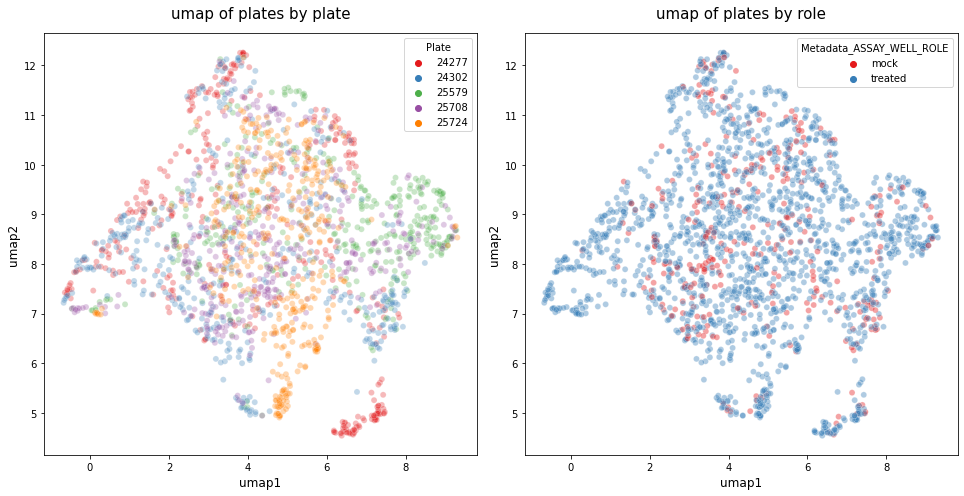

In [24]:
lim =20
method = 'umap'
for model in pcas.keys():
    if model!='pure':
        a = zscores[model]['all'][cols['ALL']].copy()
        b = pd.DataFrame(umaps[model],columns=[f'{method}1',f'{method}2']).copy()
        b[b>lim]=lim
        b[b<-lim]=-lim
        c = pd.concat([a.reset_index(),b],axis=1)
        # c[c['PCA1']>50]
        print(f'{model} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5, 7))
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Plate',alpha=0.3, palette='Set1', ax=ax[0])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.4, palette='Set1', ax=ax[1])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)

        ax[0].set_title(f'{method} of plates by plate', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        # ax[2].set_title("PCA of plates by sample", fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        ax[0].set_xlabel(f'{method}1', fontsize=12)
        ax[0].set_ylabel(f'{method}2', fontsize=12)

        ax[1].set_xlabel(f'{method}1', fontsize=12)
        ax[1].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

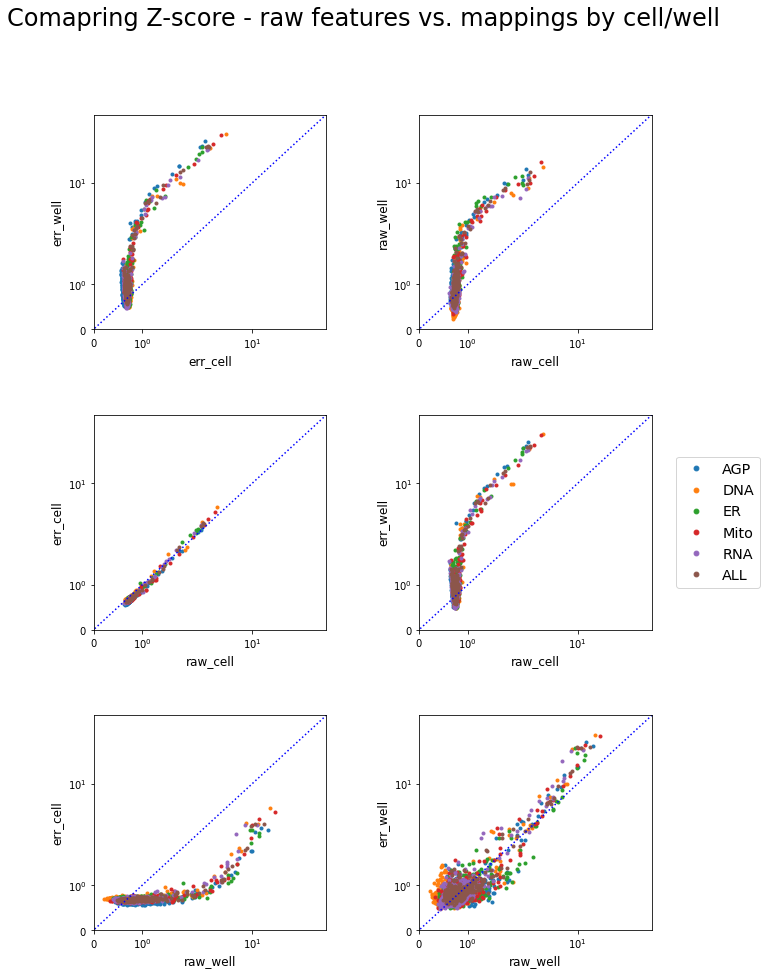

In [9]:
ncoleach = 2
ncol = ncoleach*1
nrow = 3

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle(f'Comapring Z-score - raw features vs. mappings by cell/well', fontsize = 24)


cols = CHANNELS+["ALL"]


symbols = ax[0,0].plot(err_cell, err_well, f'.')
ax[0,0].set_xlabel('err_cell')
ax[0,0].set_ylabel('err_well')
ax[0,1].plot(raw_cell, raw_well, f'.')
ax[0,1].set_xlabel('raw_cell')
ax[0,1].set_ylabel('raw_well')

xlab = ['raw_cell', 'raw_well']
ylab = ['err_cell', 'err_well']
i = 2

for raw, xlab in zip([raw_cell, raw_well], ['raw_cell', 'raw_well']):
    for err, ylab in zip([err_cell, err_well], ['err_cell', 'err_well']):
        ax[i//ncoleach,i%ncoleach].plot(raw, err, f'.')
        ax[i//ncoleach,i%ncoleach].set_xlabel(xlab)
        ax[i//ncoleach,i%ncoleach].set_ylabel(ylab)
        i += 1
        
for i in range(ncol*nrow):
    ax[i//ncol,i%ncol].set_yscale('symlog', base=10)
    ax[i//ncol,i%ncol].set_xscale('symlog', base=10)
    ax[i//ncol,i%ncol].set(xlim=(0, 70), ylim=(0, 70))
    ax[i//ncol,i%ncol].plot(range(-1, 100), range(-1, 100), 'b:')
    ax[i//ncol,i%ncol].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)
    ax[i//ncol,i%ncol].yaxis.label.set_size(12)
    ax[i//ncol,i%ncol].xaxis.label.set_size(12)
    ax[i//ncol,i%ncol].title.set_size(14)
    

fig.legend(symbols, cols, markerscale=1.6, fontsize='x-large', bbox_to_anchor=(1.06, 0.57))

plt.show()

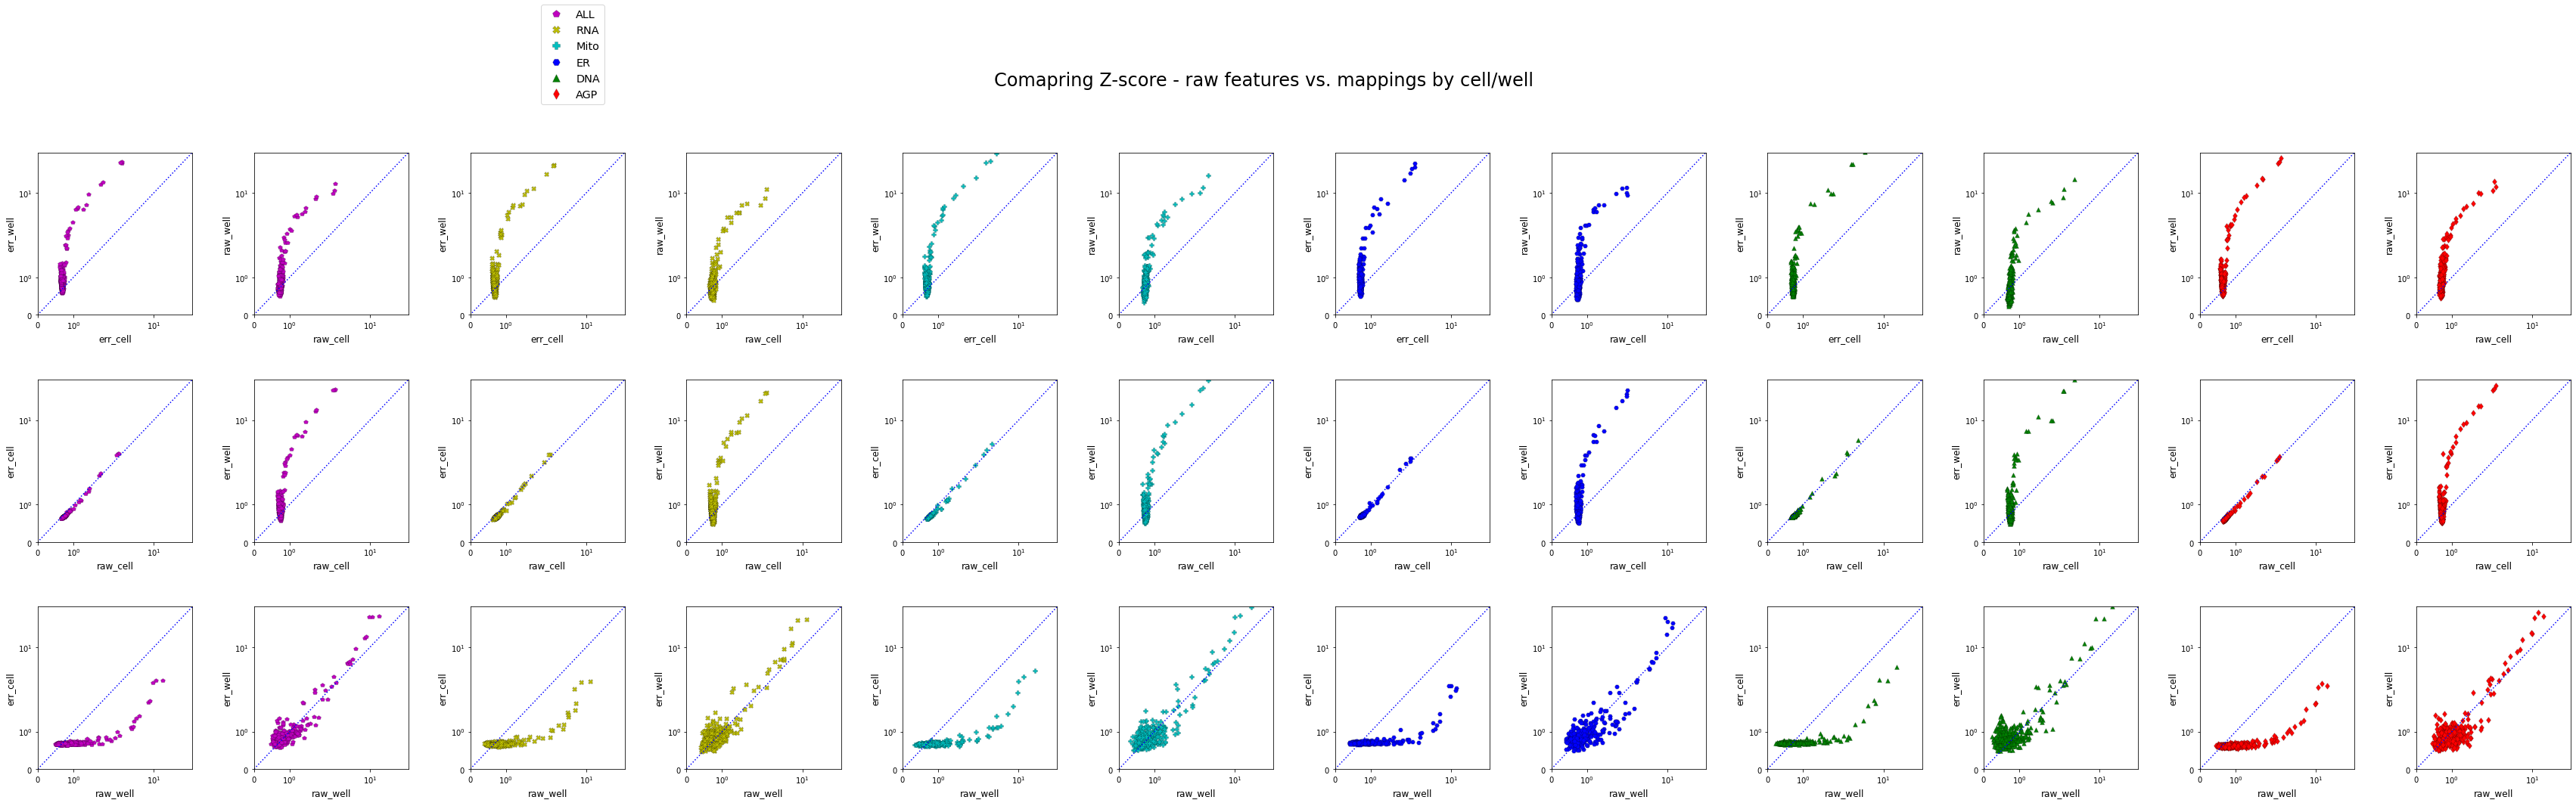

In [10]:
ncoleach = 2
ncol = ncoleach*6
nrow = 3

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle(f'Comapring Z-score - raw features vs. mappings by cell/well', fontsize = 24)

markers = ['d', '^', 'H', 'P', 'X','p']
colors = ['r', 'g', 'b', 'c', 'y', 'm']
cols = CHANNELS+["ALL"]

for arr in [cols, colors, markers]:
    arr.reverse()


symbols = cols.copy()
for j, col in enumerate(cols):
    adj_col = ncoleach*j
    symbols[j] = ax[0,0+adj_col].plot(err_cell[col], err_well[col], f'{colors[j]}{markers[j]}', markeredgecolor=(0, 0, 0, 0.2))[0]
    ax[0,0+adj_col].set_xlabel('err_cell')
    ax[0,0+adj_col].set_ylabel('err_well')
    ax[0,1+adj_col].plot(raw_cell[col], raw_well[col], f'{colors[j]}{markers[j]}', markeredgecolor=(0, 0, 0, 0.2))
    ax[0,1+adj_col].set_xlabel('raw_cell')
    ax[0,1+adj_col].set_ylabel('raw_well')

    xlab = ['raw_cell', 'raw_well']
    ylab = ['err_cell', 'err_well']
    i = 2
    for raw, xlab in zip([raw_cell[col], raw_well[col]], ['raw_cell', 'raw_well']):
        for err, ylab in zip([err_cell[col], err_well[col]], ['err_cell', 'err_well']):
            ax[i//ncoleach,i%ncoleach+adj_col].plot(raw, err, f'{colors[j]}{markers[j]}', markeredgecolor=(0, 0, 0, 0.2))
            ax[i//ncoleach,i%ncoleach+adj_col].set_xlabel(xlab)
            ax[i//ncoleach,i%ncoleach+adj_col].set_ylabel(ylab)
            i += 1

limit = max([df.max().max() for df in [raw_cell, raw_well, err_cell, err_well]])//10 *10
for i in range(ncol*nrow):
    ax[i//ncol,i%ncol].set_yscale('symlog', base=10)
    ax[i//ncol,i%ncol].set_xscale('symlog', base=10)
    ax[i//ncol,i%ncol].set(xlim=(0, limit), ylim=(0, limit))
    ax[i//ncol,i%ncol].plot(range(-1, 100), range(-1, 100), 'b:')
    ax[i//ncol,i%ncol].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)
    ax[i//ncol,i%ncol].yaxis.label.set_size(12)
    ax[i//ncol,i%ncol].xaxis.label.set_size(12)
    ax[i//ncol,i%ncol].title.set_size(14)
    

fig.legend(symbols, cols, loc='right', markerscale=1.6, fontsize='x-large', bbox_to_anchor=(0.3, 1))

plt.show()

In [11]:
def get_scaler(df, by_well):
    _, _, channels = list_columns(df)
    channels_cols = [col for ch_cols in channels.values() for col in ch_cols]
    df = df[channels_cols]

    if by_well:
        df = df.groupby(by=['Plate', LABEL_FIELD, 'Metadata_broad_sample', 'Image_Metadata_Well']).apply(lambda g: g.mean())

    df_mock = df[df.index.isin(['mock'], 1)]

    scaler = StandardScaler()
    scaler.fit(df_mock)
    del df_mock
    
    return scaler

plate_num = 25708
df = load_plate_csv(f'{err_fld}/{plate_num}.csv')
scaler_err_cell = get_scaler(df, False)
scaler_err_well = get_scaler(df, True)
df = load_plate_csv(f'{raw_fld}/{plate_num}.csv')
scaler_raw_cell = get_scaler(df, False)
scaler_raw_well = get_scaler(df, True)


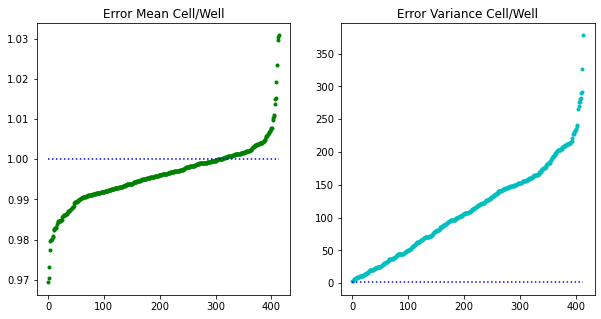

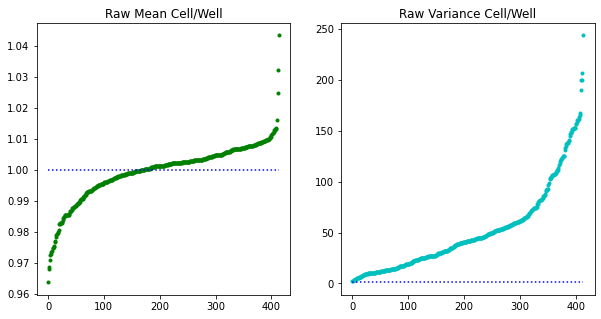

In [13]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(2*5,1*5))

ratio_err_mean = scaler_err_cell.mean_/scaler_err_well.mean_
ratio_err_mean.sort()
ax1[0].plot(range(414), ratio_err_mean, 'g.')
ax1[0].set_title('Error Mean Cell/Well')

ratio_err_var = scaler_err_cell.var_/scaler_err_well.var_
ratio_err_var.sort()
ax1[1].plot(range(414), ratio_err_var, 'c.')
ax1[1].set_title('Error Variance Cell/Well')


fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(2*5,1*5))

ratio_raw_mean = scaler_raw_cell.mean_/scaler_raw_well.mean_
ratio_raw_mean.sort()
ax2[0].plot(range(414), ratio_raw_mean, 'g.')
ax2[0].set_title('Raw Mean Cell/Well')

ratio_raw_var = scaler_raw_cell.var_/scaler_raw_well.var_
ratio_raw_var.sort()
ax2[1].plot(range(414), ratio_raw_var, 'c.')
ax2[1].set_title('Raw Variance Cell/Well')


for ax in [ax1, ax2]:
    for sub_ax in ax:
#         sub_ax.set_yscale('symlog', base=10)
#         sub_ax.set_xscale('symlog', base=10)
        sub_ax.plot(range(414), [1]*414, 'b:')